In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load the CSV files for electron and proton flux
df_electron = pd.read_csv('C:\\Users\\shahi\\OneDrive\\Desktop\\Fatema_NASA\\Van_Allen\\3_days_electron_flux.csv')
df_proton = pd.read_csv('C:\\Users\\shahi\\OneDrive\\Desktop\\Fatema_NASA\\Van_Allen\\proton_flux_3_days.csv')

# Print to verify
print(df_electron.head())
print(df_proton.head())


               time_tag  satellite        flux   energy
0  2024-08-25T12:10:00Z         16   43.201927  >=2 MeV
1  2024-08-25T12:15:00Z         16    9.090318  >=2 MeV
2  2024-08-25T12:20:00Z         16  123.123161  >=2 MeV
3  2024-08-25T12:25:00Z         16  136.516174  >=2 MeV
4  2024-08-25T12:30:00Z         16    4.000000  >=2 MeV
               time_tag  satellite      flux     energy
0  2024-08-25T12:10:00Z         18  0.341341    >=1 MeV
1  2024-08-25T12:10:00Z         18  0.193341   >=10 MeV
2  2024-08-25T12:10:00Z         18  0.184341  >=100 MeV
3  2024-08-25T12:10:00Z         18  0.186341   >=30 MeV
4  2024-08-25T12:10:00Z         18  0.196341    >=5 MeV


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Load the datasets (assuming they are loaded as df_electron and df_proton)
df_electron = pd.read_csv('C:\\Users\\shahi\\OneDrive\\Desktop\\Fatema_NASA\\Van_Allen\\3_days_electron_flux.csv')
df_proton = pd.read_csv('C:\\Users\\shahi\\OneDrive\\Desktop\\Fatema_NASA\\Van_Allen\\proton_flux_3_days.csv')

# Convert 'time_tag' to datetime
df_electron['time_tag'] = pd.to_datetime(df_electron['time_tag'])
df_proton['time_tag'] = pd.to_datetime(df_proton['time_tag'])

# Set 'time_tag' as index
df_electron.set_index('time_tag', inplace=True)
df_proton.set_index('time_tag', inplace=True)

# Handle missing values in 'flux' column
imputer = SimpleImputer(strategy='mean')
df_electron['flux'] = imputer.fit_transform(df_electron[['flux']])
df_proton['flux'] = imputer.fit_transform(df_proton[['flux']])

# Normalize the 'flux' columns
scaler_electron = MinMaxScaler()
scaler_proton = MinMaxScaler()
df_electron['flux_scaled'] = scaler_electron.fit_transform(df_electron[['flux']])
df_proton['flux_scaled'] = scaler_proton.fit_transform(df_proton[['flux']])


In [5]:
# Merge datasets on timestamp index
df_combined = pd.merge(df_electron[['flux_scaled']], df_proton[['flux_scaled']], left_index=True, right_index=True, suffixes=('_electron', '_proton'))

# Rename columns for clarity
df_combined.columns = ['electron_flux', 'proton_flux']

print(df_combined.head())


                           electron_flux  proton_flux
time_tag                                             
2024-08-25 12:10:00+00:00       0.156084     0.000926
2024-08-25 12:10:00+00:00       0.156084     0.000292
2024-08-25 12:10:00+00:00       0.156084     0.000253
2024-08-25 12:10:00+00:00       0.156084     0.000262
2024-08-25 12:10:00+00:00       0.156084     0.000304


In [6]:
import numpy as np

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length (e.g., 24 for 24 time steps; adjust as needed)
seq_length = 24  # Adjust based on your specific requirements

# Create sequences from the combined data
X_combined, y_combined = create_sequences(df_combined.values, seq_length)

# Check the shape of the created sequences
print(f"Input shape: {X_combined.shape}")
print(f"Output shape: {y_combined.shape}")


Input shape: (6872, 24, 2)
Output shape: (6872, 2)


In [7]:
# Split data into training and testing sets
split_combined = int(0.8 * len(X_combined))
X_train_combined, X_test_combined = X_combined[:split_combined], X_combined[split_combined:]
y_train_combined, y_test_combined = y_combined[:split_combined], y_combined[split_combined:]

# Reshape the data for LSTM input
X_train_combined = X_train_combined.reshape((X_train_combined.shape[0], X_train_combined.shape[1], 2))  # Two features: electron_flux and proton_flux
X_test_combined = X_test_combined.reshape((X_test_combined.shape[0], X_test_combined.shape[1], 2))

print(f"Training input shape: {X_train_combined.shape}")
print(f"Testing input shape: {X_test_combined.shape}")


Training input shape: (5497, 24, 2)
Testing input shape: (1375, 24, 2)


C:\Users\shahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.0180 - val_loss: 0.0029
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0034 - val_loss: 0.0019


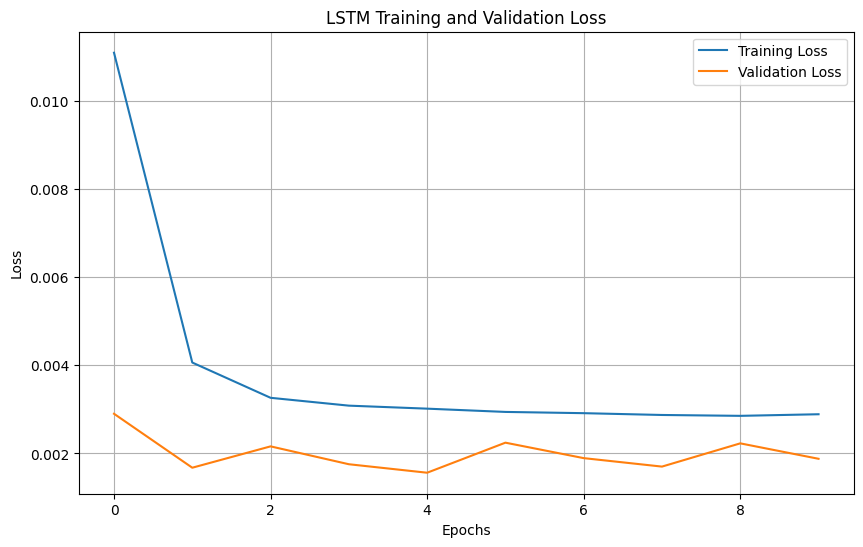

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model_combined = Sequential()
model_combined.add(LSTM(50, activation='relu', input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])))
model_combined.add(Dense(2))  # Output two features: electron_flux and proton_flux
model_combined.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_combined = model_combined.fit(X_train_combined, y_train_combined, epochs=50, batch_size=32,
                                      validation_data=(X_test_combined, y_test_combined),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
